#### Importing Libraries

In [34]:
import sys
sys.path.append('../')
import pandas as pd
from src.utils import check_missing_data
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading Data

In [2]:
df_data = pd.read_csv('../data/data.csv')

In [3]:
df_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [4]:
print(df_data.columns)

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')


#### Data Quality Assessemnt

In [5]:
check_missing_data(df_data)

'Success: No missing values.'

#### Calculating RFMS Metrics

- Recency (R): The number of days since the customer's last transaction.
- Frequency (F): The total number of transactions made by the customer.
- Monetary (M): The total value of transactions made by the customer.
- Stability (S): The consistency of transactions over time. This can be measured using the standard deviation of the transaction values over time.

In [6]:
df_data['TransactionStartTime'] = pd.to_datetime(df_data['TransactionStartTime'])

In [9]:
max_date = df_data['TransactionStartTime'].max()
print(max_date)

2019-02-13 10:01:28+00:00


In [10]:
min_date = df_data['TransactionStartTime'].min()
print(min_date)

2018-11-15 02:18:49+00:00


In [11]:
# Calculate Recency
recency_df = df_data.groupby('CustomerId')['TransactionStartTime'].max().reset_index()
recency_df['Recency'] = (max_date - recency_df['TransactionStartTime']).dt.days
recency_df.drop('TransactionStartTime', axis=1, inplace=True)

In [12]:
recency_df.head()

,CustomerId,Recency
0,CustomerId_1,83
1,CustomerId_10,83
2,CustomerId_1001,89
3,CustomerId_1002,25
4,CustomerId_1003,11


In [13]:
print(len(recency_df))

3742


In [20]:
check_missing_data(recency_df)

'Success: No missing values.'

In [14]:
# Calculate Frequency
frequency_df = df_data.groupby('CustomerId')['TransactionId'].count().reset_index()
frequency_df.columns = ['CustomerId', 'Frequency']

In [15]:
frequency_df.head()

,CustomerId,Frequency
0,CustomerId_1,1
1,CustomerId_10,1
2,CustomerId_1001,5
3,CustomerId_1002,11
4,CustomerId_1003,6


In [22]:
check_missing_data(frequency_df)

'Success: No missing values.'

In [16]:
# Calculate Monetary
monetary_df = df_data.groupby('CustomerId')['Amount'].sum().reset_index()
monetary_df.columns = ['CustomerId', 'Monetary']

In [17]:
monetary_df.head()

,CustomerId,Monetary
0,CustomerId_1,-10000.0
1,CustomerId_10,-10000.0
2,CustomerId_1001,20000.0
3,CustomerId_1002,4225.0
4,CustomerId_1003,20000.0


In [23]:
check_missing_data(monetary_df)

'Success: No missing values.'

In [18]:
# Calculate Stability
stability_df = df_data.groupby('CustomerId')['Amount'].std().reset_index()
stability_df.columns = ['CustomerId', 'Stability']

In [19]:
stability_df.head()

,CustomerId,Stability
0,CustomerId_1,NaN
1,CustomerId_10,NaN
2,CustomerId_1001,6558.963333
3,CustomerId_1002,560.498966
4,CustomerId_1003,6030.478146


In [24]:
check_missing_data(stability_df)

,Column Name,Missing Values,Percentage Missing
1,Stability,712,19.027258


In [25]:
# data cleaning
stability_df['Stability'].fillna(0, inplace=True)

C:\Users\abraham.shimelis\AppData\Local\Temp\ipykernel_13920\1829478075.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stability_df['Stability'].fillna(0, inplace=True)


In [26]:
check_missing_data(stability_df)

'Success: No missing values.'

In [30]:
# Merge RFMS dataframes
rfms_df = recency_df.merge(frequency_df, on='CustomerId')
rfms_df = rfms_df.merge(monetary_df, on='CustomerId')
rfms_df = rfms_df.merge(stability_df, on='CustomerId')

In [31]:
rfms_df.head()

,CustomerId,Recency,Frequency,Monetary,Stability
0,CustomerId_1,83,1,-10000.0,0.000000
1,CustomerId_10,83,1,-10000.0,0.000000
2,CustomerId_1001,89,5,20000.0,6558.963333
3,CustomerId_1002,25,11,4225.0,560.498966
4,CustomerId_1003,11,6,20000.0,6030.478146


In [32]:
check_missing_data(rfms_df)

'Success: No missing values.'

#### Visualize Transactions in RFMS Space

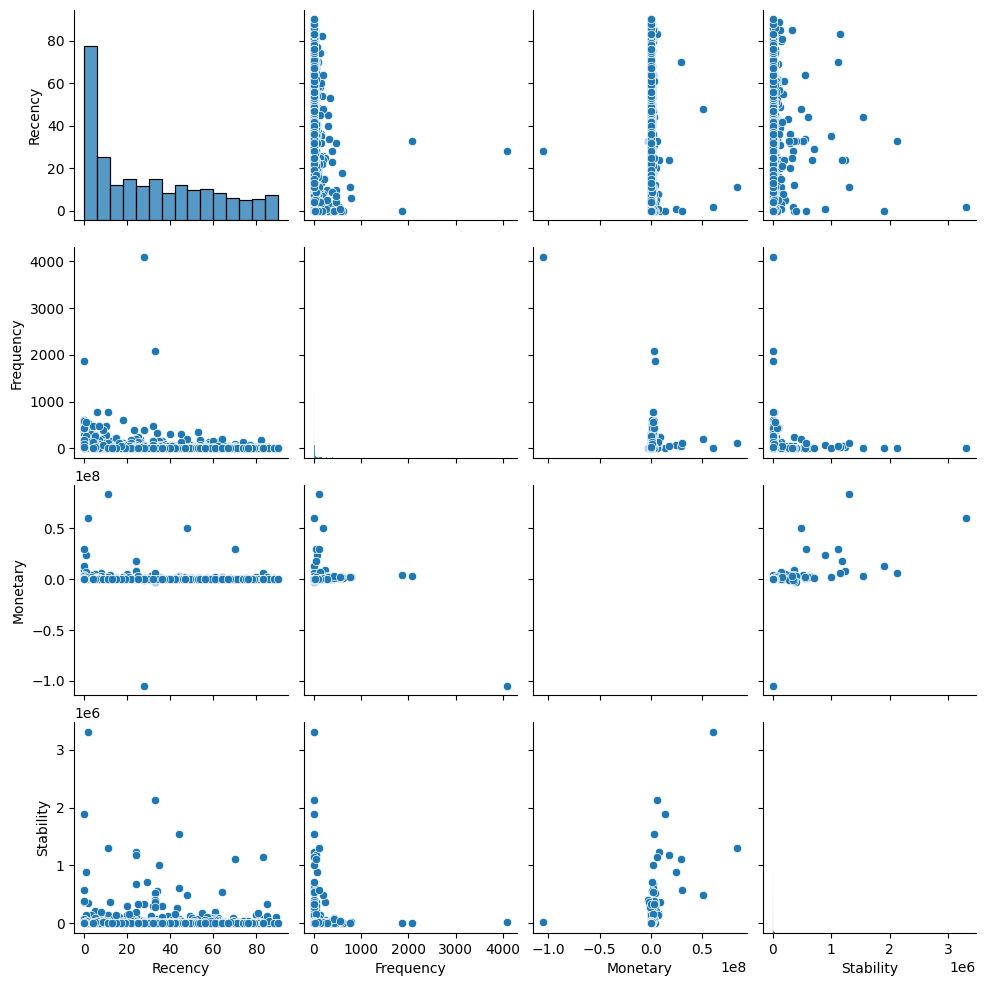

In [35]:
# Pair plot to visualize RFMS metrics
sns.pairplot(rfms_df)
plt.show()

In [36]:
print(rfms_df.columns)

Index(['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Stability'], dtype='object')


#### # Calculating RFMS correlations

In [37]:
recency_frequency_corr = rfms_df['Recency'].corr(rfms_df['Frequency'])
print(f"The correlation between Recency and Frequency is: {recency_frequency_corr}")

The correlation between Recency and Frequency is: -0.15391235948846044


In [38]:
recency_monetary_corr = rfms_df['Recency'].corr(rfms_df['Monetary'])
print(f"The correlation between Recency and Monetary is: {recency_monetary_corr}")

The correlation between Recency and Monetary is: -0.028274596995313057


In [39]:
recency_stability_corr = rfms_df['Recency'].corr(rfms_df['Stability'])
print(f"The correlation between Recency and Stability is: {recency_stability_corr}")

The correlation between Recency and Stability is: -0.015581877989222484


In [40]:
frequency_stability_corr = rfms_df['Frequency'].corr(rfms_df['Stability'])
print(f"The correlation between Frequency and Stability is: {frequency_stability_corr}")

The correlation between Frequency and Stability is: 0.011700957906111902


In [42]:
frequency_monetary_corr = rfms_df['Monetary'].corr(rfms_df['Frequency'])
print(f"The correlation between Frequency and Monetary is: {frequency_monetary_corr}")

The correlation between Frequency and Monetary is: -0.3660949019175959
